<a href="https://colab.research.google.com/github/arumshin-dev/python_conda_jupyter/blob/main/codeit/3_5_14_LangGraph_1_%E1%84%8C%E1%85%A9%E1%84%80%E1%85%A5%E1%86%AB%E1%84%87%E1%85%AE%E1%86%AB%E1%84%80%E1%85%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LangGraph 실습 1: 조건 분기 (Conditional Branching)

- LangGraph의 핵심 3요소(State, Node, Edge)를 이해한다
- 조건부 엣지(Conditional Edge)로 분기 로직을 구현한다
- 그래프를 시각화하고 실행 흐름을 추적한다

---

## 0. 환경 설정

In [ ]:
# 패키지 설치
!pip install -q langchain-openai langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.7/84.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 8.0 MB/s eta 0:00:00


In [ ]:
# API 키 설정
import os
from getpass import getpass

# API 키 설정
os.environ["OPENAI_API_KEY"] = getpass("OpenAI API Key: ")

OpenAI API Key: ··········


## 1. 핵심 개념 복습

### LangGraph 3대 요소

| 요소 | 비유 | 역할 |
|------|------|------|
| **State** | 공유 문서 (Google Docs) | 모든 노드가 읽고 쓰는 기억 저장소 |
| **Node** | 일꾼 | 실제 작업 수행 (LLM 호출, 도구 사용 등) |
| **Edge** | 길 | 노드 간 이동 경로 (일반 / 조건부) |

## 2. 시나리오: 날씨 기반 활동 추천

```
사용자 입력 (날씨)
       ↓
  [check_weather] ← LLM이 날씨 판단
       ↓
   좋음 / 나쁨?
     ↙     ↘
[go_for_walk] [code_at_home]
     ↘     ↙
      종료
```

## 3. 코드 구현

In [ ]:
from typing import TypedDict, Literal
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END

# LLM 설정
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [ ]:
# ============================================
# [1] State 정의: 그래프 전체가 공유하는 데이터
# ============================================

class WeatherState(TypedDict):
    weather: str      # 사용자가 입력한 날씨
    decision: str     # LLM의 판단 결과 (good/bad)
    activity: str     # 최종 추천 활동

In [ ]:
# ============================================
# [2] Node 정의: 실제 작업을 수행하는 함수들
# ============================================

def check_weather(state: WeatherState) -> dict:
    """날씨를 보고 좋음/나쁨을 판단하는 노드"""
    print("[check_weather] 날씨 확인 중...")

    weather = state["weather"]

    # LLM에게 판단 요청
    response = llm.invoke(
        f"날씨가 '{weather}'입니다. "
        "야외 활동하기 좋으면 'good', 안 좋으면 'bad'라고만 답해주세요."
    )

    decision = response.content.strip().lower()
    print(f"   → LLM 판단: {decision}")

    # State 업데이트 (변경된 부분만 반환)
    return {"decision": decision}


def go_for_walk(state: WeatherState) -> dict:
    """산책 추천 노드"""
    print("[go_for_walk] 산책을 추천합니다!")
    return {"activity": "산책하기~~"}


def code_at_home(state: WeatherState) -> dict:
    """집콕 추천 노드"""
    print("[code_at_home] 집에서 코딩을 추천합니다!")
    return {"activity": "집에서 코딩하기!!!"}

In [ ]:
# ============================================
# [3] Router 정의: 조건부 분기 로직
# ============================================

def weather_router(state: WeatherState) -> Literal["go_for_walk", "code_at_home"]:
    """
    decision 값에 따라 다음 노드를 결정하는 라우터
    - 반환값이 다음에 실행될 노드 이름
    """
    print(f"[Router] decision='{state['decision']}' → ", end="")

    if "good" in state["decision"]:
        print("go_for_walk로 이동")
        return "go_for_walk"
    else:
        print("code_at_home으로 이동")
        return "code_at_home"

In [ ]:
# ============================================
# [4] 그래프 조립
# ============================================

# 그래프 생성 (State 타입 지정)
workflow = StateGraph(WeatherState)

# 노드 등록
workflow.add_node("check_weather", check_weather)
workflow.add_node("go_for_walk", go_for_walk)
workflow.add_node("code_at_home", code_at_home)

# 엣지 연결
workflow.add_edge(START, "check_weather")  # 시작 → check_weather

# 조건부 엣지: check_weather 이후 router 함수로 분기
workflow.add_conditional_edges(
    source="check_weather",      # 출발 노드
    path=weather_router,          # 분기 결정 함수
    path_map={                    # 반환값 → 도착 노드 매핑
        "go_for_walk": "go_for_walk",
        "code_at_home": "code_at_home",
    }
)

# 종료 엣지
workflow.add_edge("go_for_walk", END)
workflow.add_edge("code_at_home", END)

# 컴파일
app = workflow.compile()

print("그래프 컴파일 완료!")

그래프 컴파일 완료!


## 4. 그래프 시각화

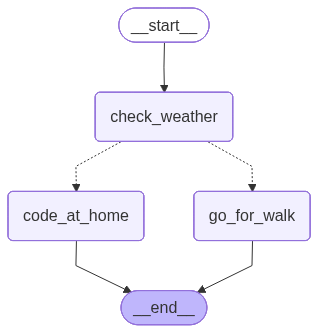

In [ ]:
from IPython.display import Image, display

# Mermaid 다이어그램으로 시각화
display(Image(app.get_graph().draw_mermaid_png()))

## 5. 실행 테스트

In [ ]:
# 테스트 1: 좋은 날씨
print("=" * 50)
print("테스트 1: 화창한 날씨")
print("=" * 50)

result1 = app.invoke({
    "weather": "맑고 화창함, 기온 22도",
    "decision": "",
    "activity": ""
})

print(f"\n최종 결과: {result1['activity']}")

테스트 1: 화창한 날씨
[check_weather] 날씨 확인 중...
   → LLM 판단: good
[Router] decision='good' → go_for_walk로 이동
[go_for_walk] 산책을 추천합니다!

최종 결과: 산책하기~~


In [ ]:
# 테스트 2: 나쁜 날씨
print("=" * 50)
print("테스트 2: 태풍")
print("=" * 50)

result2 = app.invoke({
    "weather": "태풍 경보, 강풍과 폭우",
    "decision": "",
    "activity": ""
})

print(f"\n최종 결과: {result2['activity']}")

테스트 2: 태풍
[check_weather] 날씨 확인 중...
   → LLM 판단: bad
[Router] decision='bad' → code_at_home으로 이동
[code_at_home] 집에서 코딩을 추천합니다!

최종 결과: 집에서 코딩하기!!!


## 6. 스트리밍으로 실행 과정 추적

In [ ]:
# stream()으로 각 노드 실행 후 상태 변화 확인
print("=" * 50)
print("스트리밍 실행: 각 단계별 State 변화 추적")
print("=" * 50)

for step in app.stream({"weather": "소나기가 내림", "decision": "", "activity": ""}):
    print(f"\n----현재 State:")
    for key, value in step.items():
        print(f"   노드 '{key}' 실행 완료 → {value}")

스트리밍 실행: 각 단계별 State 변화 추적
[check_weather] 날씨 확인 중...
   → LLM 판단: bad
[Router] decision='bad' → code_at_home으로 이동

----현재 State:
   노드 'check_weather' 실행 완료 → {'decision': 'bad'}
[code_at_home] 집에서 코딩을 추천합니다!

----현재 State:
   노드 'code_at_home' 실행 완료 → {'activity': '집에서 코딩하기!!!'}


---

## 혼자해보기 문제

### 문제 1: 분기 추가하기
현재는 good/bad 두 가지 분기만 있습니다.
**"애매한 날씨"(예: 흐림)** 일 때 `"read_book"` 노드로 가도록 수정해보세요.

### 문제 2: State 확장하기
State에 `"temperature"` (기온) 필드를 추가하고,
기온이 30도 이상이면 날씨가 좋아도 `"code_at_home"`으로 가도록 수정해보세요.